<a href="https://colab.research.google.com/github/gksals8378/Space_Radio_Disaster_Forecast/blob/main/SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

data = pd.read_csv("/content/drive/MyDrive/data/AI_우주관측_경진대회/ai_competition_train.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5479 entries, 0 to 5478
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    5479 non-null   object 
 1   flux    4228 non-null   float64
dtypes: float64(1), object(1)
memory usage: 85.7+ KB


In [ ]:
data

,date,flux
0,2008-01-01,94.800
1,2008-01-02,96.930
2,2008-01-03,97.710
3,2008-01-04,90.090
4,2008-01-05,90.740
...,...,...
5474,2022-12-27,120.425
5475,2022-12-28,125.205
5476,2022-12-29,NaN
5477,2022-12-30,128.634


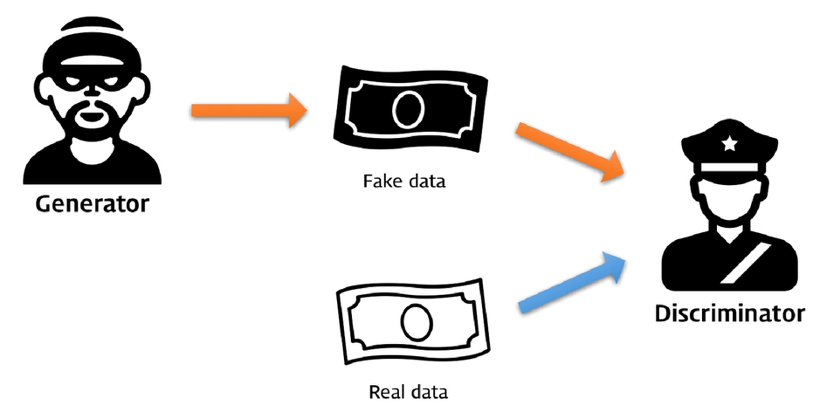

# Generator
- G는 random한 noise를 생성해내는 vector z를 input으로 하며(그림의 Noise)

# Discriminator
- D가 판별하고자 하는 input image(여기서는 28X28의 mnist 이미지)를 output으로 하는 neural network unit이라고 할 수 있다.

이렇게 GAN의 코어가 되는 모델은 D와 G 두 가지이다.

학습 과정에서는 실제 mnist 이미지, Real Image를 D로 하여금 '진짜'라고 학습시키는 1번 과정,

그리고 vector z와 G에 의해 생성된 Fake Image를 '가짜'라고 학습시키는 2번과정으로 나뉜다.

여기서 유의할 점은 D가 두번 학습되고 G는 1번 학습되는 것이 아니라, 1번 과정에서의 Real Image와 Fake Image를 D의 x input으로 합쳐서 학습한다는 것이다.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/data/AI_우주관측_경진대회/ai_competition_train.csv")

In [ ]:
data

,date,flux
0,2008-01-01,94.800
1,2008-01-02,96.930
2,2008-01-03,97.710
3,2008-01-04,90.090
4,2008-01-05,90.740
...,...,...
5474,2022-12-27,120.425
5475,2022-12-28,125.205
5476,2022-12-29,NaN
5477,2022-12-30,128.634


In [ ]:
data[data['flux'].isnull()]

,date,flux
63,2008-03-04,NaN
103,2008-04-13,NaN
106,2008-04-16,NaN
196,2008-07-15,NaN
200,2008-07-19,NaN
...,...,...
5291,2022-06-27,NaN
5292,2022-06-28,NaN
5314,2022-07-20,NaN
5470,2022-12-23,NaN


In [ ]:
data['date'] = pd.to_datetime(data['date'])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# RobustScaler를 초기화
scaler = MinMaxScaler()

# 데이터의 'flux' 열을 추출하여 2D 배열로 변환
flux_data = data['flux'].values.reshape(-1, 1)

# RobustScaler를 사용하여 'flux' 열을 정규화
flux_data_normalized = scaler.fit_transform(flux_data)

# 정규화된 데이터를 'flux' 열에 다시 할당
data['flux'] = flux_data_normalized

In [ ]:
train_data = data.dropna()

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam

In [ ]:
# Generator 모델 정의
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Tanh()  # 결측치 생성을 위해 Tanh 활성화 함수 사용
        )

    def forward(self, x):
        return self.model(x)

# Discriminator 모델 정의
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()  # 판별 결과를 확률로 반환
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Generator 모델 초기화
input_dim = 2  # 날짜(date) 및 기존 flux를 입력으로 사용
output_dim = 1  # 결측치 생성 (flux) - 1차원 값
generator = Generator(input_dim, output_dim)

# Discriminator 모델 초기화
input_dim = 1  # 데이터의 flux 값을 판별
discriminator = Discriminator(input_dim)

# GAN 모델 초기화 및 손실 함수 설정
generator = Generator(input_dim, output_dim)
discriminator = Discriminator(input_dim)
criterion = nn.BCELoss()
d_optimizer = Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = Adam(generator.parameters(), lr=0.0002)

In [ ]:
# 결측치 생성 및 데이터 프레임 완성
with torch.no_grad():
    some_input = torch.randn(len(data[data['flux'].isnull()]), input_dim)  # 예시: 랜덤한 입력 생성

    generated_flux = generator(some_input)  # some_input은 생성기에 입력할 데이터
    data.loc[data['flux'].isnull(), 'flux'] = generated_flux

# 완성된 데이터 프레임 저장
data.to_csv("completed_data.csv", index=False)

In [ ]:
filled_data_GNA =pd.read_csv('/content/completed_data.csv')

In [ ]:
filled_data_GNA

,date,flux
0,2008-01-01,0.231133
1,2008-01-02,0.242204
2,2008-01-03,0.246258
3,2008-01-04,0.206653
4,2008-01-05,0.210031
...,...,...
5474,2022-12-27,0.364319
5475,2022-12-28,0.389163
5476,2022-12-29,0.079080
5477,2022-12-30,0.406985


In [ ]:
na_data = pd.read_csv("/content/drive/MyDrive/data/AI_우주관측_경진대회/ai_competition_train.csv")

In [ ]:
from scipy.interpolate import CubicSpline

data = pd.read_csv("/content/drive/MyDrive/data/AI_우주관측_경진대회/ai_competition_train.csv")

data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# 결측치가 있는 행 추출
missing_data = data[data['flux'].isnull()]

# 결측치가 아닌 행에서 Cubic Spline 보간을 수행하여 결측치를 채움
not_missing_data = data[~data['flux'].isnull()]

# 날짜 및 flux 데이터 추출
dates = not_missing_data.index
flux_values = not_missing_data['flux'].values

# Cubic Spline 보간 객체 생성
cs = CubicSpline(dates, flux_values)

# 결측치가 시작하는 날짜와 끝나는 날짜 추출
missing_start_date = missing_data.index.min()
missing_end_date = missing_data.index.max()

# 결측치가 시작하는 날짜부터 끝나는 날짜까지의 날짜 범위 생성
interpolation_dates = pd.date_range(start=missing_start_date, end=missing_end_date)

# Cubic Spline 보간을 사용하여 결측치 보간
missing_flux_values = cs(interpolation_dates)

# 결측치를 보간한 값으로 데이터 프레임 업데이트
data.loc[interpolation_dates, 'flux'] = missing_flux_values

# 결과를 저장할 수도 있습니다
data.to_csv("filled_data_spline.csv", index=False)

In [ ]:
filled_data_spline = pd.read_csv("/content/filled_data_spline.csv")

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/data/AI_우주관측_경진대회/ai_competition_train.csv")
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# 결측치를 선형 보간하여 채우기
data['flux'].interpolate(method='time', inplace=True)

# 결과를 저장할 수도 있습니다
data.to_csv('filled_data_linear.csv', index=False)

In [ ]:
filled_data_linear = pd.read_csv("/content/filled_data_linear.csv")

In [ ]:
# GAN fill
filled_data_GNA

,date,flux
0,2008-01-01,0.231133
1,2008-01-02,0.242204
2,2008-01-03,0.246258
3,2008-01-04,0.206653
4,2008-01-05,0.210031
...,...,...
5474,2022-12-27,0.364319
5475,2022-12-28,0.389163
5476,2022-12-29,0.079080
5477,2022-12-30,0.406985


In [ ]:
# fillna. mean
data

,flux
date,
2008-01-01,94.8000
2008-01-02,96.9300
2008-01-03,97.7100
2008-01-04,90.0900
2008-01-05,90.7400
...,...
2022-12-27,120.4250
2022-12-28,125.2050
2022-12-29,126.9195


In [ ]:
# 원본 (na)
na_data

,date,flux
0,2008-01-01,94.800
1,2008-01-02,96.930
2,2008-01-03,97.710
3,2008-01-04,90.090
4,2008-01-05,90.740
...,...,...
5474,2022-12-27,120.425
5475,2022-12-28,125.205
5476,2022-12-29,NaN
5477,2022-12-30,128.634


In [ ]:
#filled_data_spline
filled_data_spline

,flux
0,94.800000
1,96.930000
2,97.710000
3,90.090000
4,90.740000
...,...
5474,120.425000
5475,125.205000
5476,125.354227
5477,128.634000


In [ ]:
filled_data_linear

,flux
0,94.8000
1,96.9300
2,97.7100
3,90.0900
4,90.7400
...,...
5474,120.4250
5475,125.2050
5476,126.9195
5477,128.6340


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# 데이터 프레임 로드
data = pd.read_csv("/content/drive/MyDrive/data/AI_우주관측_경진대회/ai_competition_train.csv")

# 결측치가 있는 행 추출
missing_data = data[data['flux'].isnull()]

# 결측치가 아닌 행에서 ARIMA 모델을 사용하여 결측치를 예측 및 채움
not_missing_data = data[~data['flux'].isnull()]

# 날짜 및 flux 데이터 추출
dates = not_missing_data.index
flux_values = not_missing_data['flux'].values

# ARIMA 모델 학습
model = ARIMA(flux_values, order=(1,1,1))  # ARIMA 모델 생성
model_fit = model.fit()  # 모델 학습

# 결측치를 예측
predicted_flux = model_fit.forecast(steps=len(missing_data))

# 결측치를 예측한 값으로 데이터 프레임 업데이트
missing_data['flux'] = predicted_flux

# 결과를 원래 데이터 프레임과 병합
data.update(missing_data)

# 결과를 저장할 수도 있습니다
data.to_csv("filled_data_ARIMA.csv", index=False)


<ipython-input-28-b496b7493d0e>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_data['flux'] = predicted_flux


In [ ]:
filled_data_ARIMA = pd.read_csv("/content/filled_data_ARIMA.csv")

In [ ]:
import statsmodels.tsa.statespace.sarimax as sarimax

# 데이터 프레임 로드
data = pd.read_csv("/content/drive/MyDrive/data/AI_우주관측_경진대회/ai_competition_train.csv")

# 결측치가 있는 행 추출
missing_data = data[data['flux'].isnull()]

# 결측치가 아닌 행에서 ARIMA 모델을 사용하여 결측치를 예측 및 채움
not_missing_data = data[~data['flux'].isnull()]

# 날짜 및 flux 데이터 추출
dates = not_missing_data.index
flux_values = not_missing_data['flux'].values

# 하이퍼 파라미터
p = 1
d = 1
q = 1
P = 1
D = 1
Q = 1

# SARIMA 모델을 생성합니다.
model = sarimax.SARIMAX(flux_values, order=(p, d, q), seasonal_order=(P, D, Q, 7))
model_fit = model.fit()

# SARIMA 모델을 사용하여 결측치를 예측
predictions = model_fit.predict(start=missing_data.index[0], end=missing_data.index[-1], dynamic=False)

# predictions 배열의 길이를 missing_data와 일치하도록 자릅니다
predictions = predictions[:len(missing_data)]

# 예측 결과를 missing_data에 할당
missing_data['flux'] = predictions

# missing_data의 'flux' 열로 결측치를 채운 뒤, data에 다시 할당
data.loc[missing_data.index, 'flux'] = missing_data['flux']

# 결과를 저장
data.to_csv("filled_data_sarimax.csv", index=False)


<ipython-input-30-5569d72800e7>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_data['flux'] = predictions


In [ ]:
filled_data_sarimax = pd.read_csv("/content/filled_data_sarimax.csv")

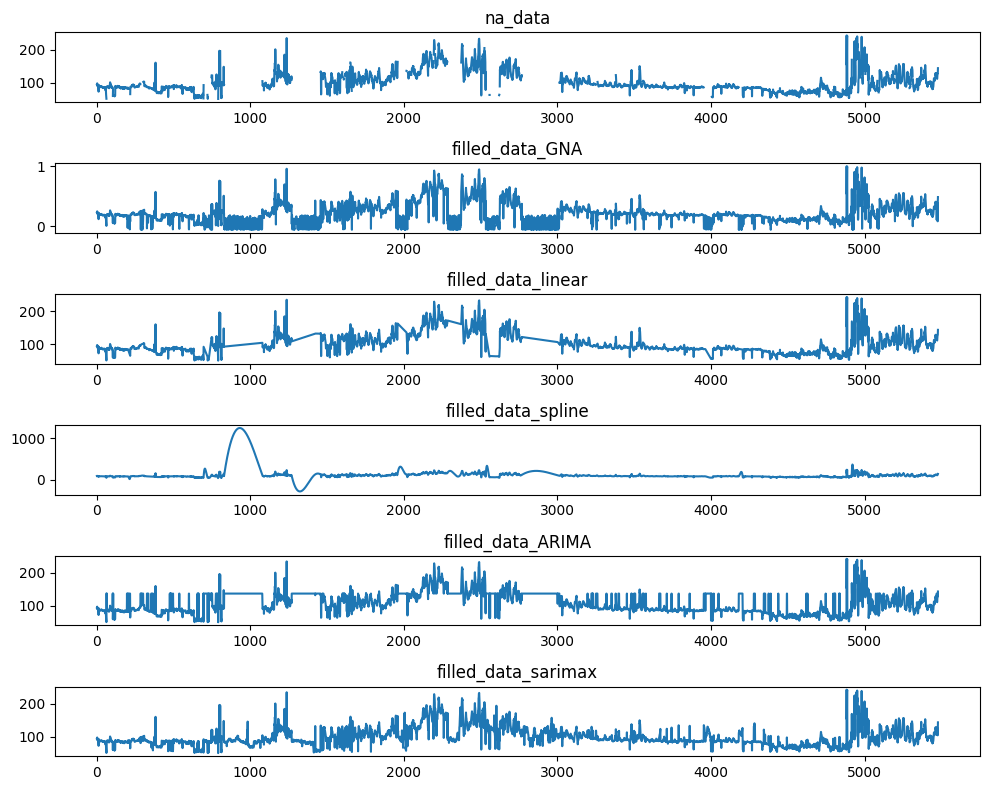

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(6, 1, figsize=(10,8))

na_data['flux'].plot(ax=axes[0])
axes[0].set_title('na_data')

filled_data_GNA['flux'].plot(ax=axes[1])
axes[1].set_title('filled_data_GNA')

filled_data_linear['flux'].plot(ax=axes[2])
axes[2].set_title('filled_data_linear')

filled_data_spline['flux'].plot(ax=axes[3])
axes[3].set_title('filled_data_spline')

filled_data_ARIMA['flux'].plot(ax=axes[4])
axes[4].set_title('filled_data_ARIMA')

filled_data_sarimax['flux'].plot(ax=axes[5])
axes[5].set_title('filled_data_sarimax')


plt.tight_layout()
plt.show()